# ACIT4610 Problem Statement 2
This assignment focuses on optimizing a financial portfolio with the single objective of
maximizing expected return. You will implement and compare different versions of
Evolutionary Programming (EP) and Evolutionary Strategies (ES), including the (μ + λ) and
(μ, λ) strategies, to determine which approach yields the best portfolio allocation.

In [1]:
""" Setup the environment for the notebook """
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils.finance import finance_manager as finance

## Data Preprocessing Section

1. Download the data
2. Calculate Monthly Returns
3. Covariance Matrix

In [5]:
""" Data Requirements:
Data Source:    Yahoo Finance
Data Type:      Historical Daily Stock Prices
Data Period:    01/01/2018 - 12/31/2022
Data Columns:   Date, Open, High, Low, Close, Volume (Can be more).
Description:    Need to have 20 different stocks to analyze and
    compute monthly returns..
"""

DATA_PERIOD = {
    'start': datetime.datetime(2018, 1, 1),
    'end': datetime.datetime(2022, 12, 31),
    'interval': '1d',
}

STOCK_TICKERS = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NOD.OL']

manager = finance.TickerManager(STOCK_TICKERS, **DATA_PERIOD)
df = manager.get_stock_history()
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
Date,,,,,,,,
2018-01-02 00:00:00-05:00,40.074355,40.578346,39.862394,40.568924,102223600,0.0,0.0,AAPL
2018-01-03 00:00:00-05:00,40.632520,41.108251,40.498282,40.561867,118071600,0.0,0.0,AAPL
2018-01-04 00:00:00-05:00,40.634870,40.853896,40.526537,40.750271,89738400,0.0,0.0,AAPL
2018-01-05 00:00:00-05:00,40.846831,41.301363,40.754982,41.214226,94640000,0.0,0.0,AAPL
2018-01-08 00:00:00-05:00,41.061146,41.357887,40.962228,41.061146,82271200,0.0,0.0,AAPL


In [7]:
manager['NOD.OL'].head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
Date,,,,,,,,
2018-01-02 00:00:00+01:00,3.980524,4.113208,3.952092,4.075298,348643,0.0,0.0,NOD.OL
2018-01-03 00:00:00+01:00,4.075298,4.122685,4.037388,4.122685,334311,0.0,0.0,NOD.OL
2018-01-04 00:00:00+01:00,4.141640,4.321711,4.132163,4.321711,567401,0.0,0.0,NOD.OL
2018-01-05 00:00:00+01:00,4.321711,4.383315,4.189028,4.369099,378158,0.0,0.0,NOD.OL
2018-01-08 00:00:00+01:00,4.369099,4.397531,4.226937,4.326450,289170,0.0,0.0,NOD.OL


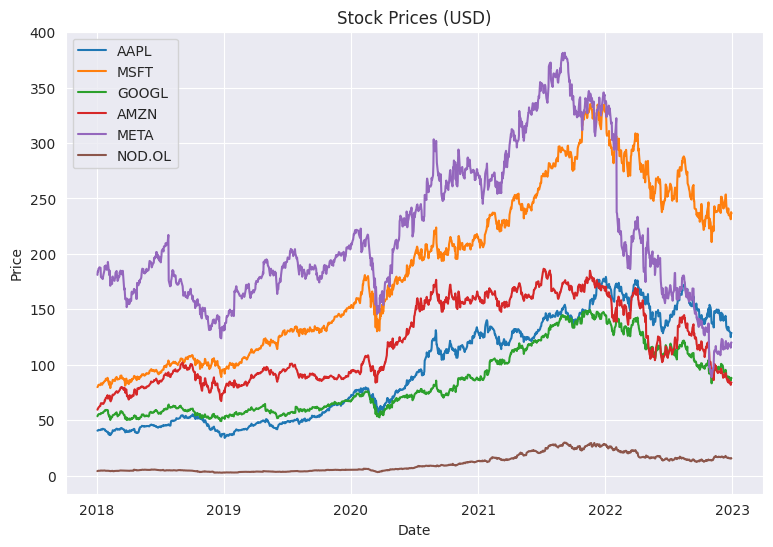

In [3]:
plt.figure(figsize=(9, 6))
for ticker in STOCK_TICKERS:
    plt.plot(manager[ticker]['Close'], label=ticker)
plt.title('Stock Prices (USD)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()